# Model 3: Text Classification with PyTorch

In [1]:
import torch
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Load the dataset

In [3]:
df = pd.read_csv('data/movies_2015_2023_preprocessed_genre.csv')
df.head()

,title,release_year,language,genre,overview,vote_average,vote_count,popularity,cleaned_overview
0,Pad Man,2018,Indisch,Humor,upon realizing extent woman affected menses se...,7.420,200.0,7.036,upon realizing extent woman affected menses se...
1,Tamasha,2015,Indisch,Humor,meeting vacation ved tara sense connection vow...,6.720,141.0,8.770,meeting vacation ved tara sense connection vow...
2,Tu Jhoothi Main Makkaar,2023,Indisch,Humor,earn extra cash mickey help couple break life ...,6.253,144.0,10.045,earn extra cash mickey help couple break life ...
3,Hindi Medium,2017,Indisch,Humor,mita raj batra affluent couple delhi chandni c...,7.300,166.0,7.001,mita raj batra affluent couple delhi chandni c...
4,Dilwale,2015,Indisch,Humor,raj mafia member one day meet girl meera chasi...,6.648,301.0,11.501,raj mafia member one day meet girl meera chasi...


## Prepare data tuples (language, cleaned overview)

In [4]:
value_tuples = [(row['language'], row['cleaned_overview']) for _, row in df.iterrows()]
print(f'Total number of value tuples: {len(value_tuples)}')
print(f'First tuple: {value_tuples[0]}')
print(f'Last tuple: {value_tuples[-1]}')

Total number of value tuples: 15500
First tuple: ('Indisch', 'upon realizing extent woman affected menses set create sanitary pad machine provide inexpensive sanitary pad woman rural india')
Last tuple: ('Italienisch', 'several european underground director turn ancient rule mankind inside shocking goresoaked interpretation god law bible world ending commandment dying')


### Train/test split

In [5]:
train_value_tuples, test_value_tuples = train_test_split(value_tuples, test_size=0.3, shuffle=True, random_state=0)
print(f'Training set size: {len(train_value_tuples)}')
print(f'Testing set size: {len(test_value_tuples)}')

Training set size: 10850
Testing set size: 4650


In [6]:
# Custom tokenizer using regex
def custom_tokenizer(text):
    if isinstance(text, float):  # Handle NaN values
        return []
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

In [7]:
# Build vocabulary
def build_vocab_from_tokens(data_iter):
    vocab_counter = Counter()
    for _, text in data_iter:
        tokens = custom_tokenizer(text)
        vocab_counter.update(tokens)
    
    vocab = {token: idx for idx, token in enumerate(vocab_counter, start=1)}  # Start index from 1
    vocab['<unk>'] = 0  # Unknown token
    return vocab

# Build vocabulary from the training data
vocab = build_vocab_from_tokens(train_value_tuples)

# Text pipeline to convert text into token indices
text_pipeline = lambda x: [vocab[token] if token in vocab else vocab['<unk>'] for token in custom_tokenizer(x)]


### mapping from language labels

In [8]:
# Step 1: Create a mapping from language labels to integers, include '<unk>' for unknown labels
language_mapping = {language: idx for idx, language in enumerate(set([label for label, _ in train_value_tuples]))}
language_mapping['<unk>'] = len(language_mapping)  # Adding an unknown label placeholder

# Step 2: Update the label_pipeline to map language strings to integers
label_pipeline = lambda x: language_mapping.get(x, language_mapping['<unk>'])

# Example: Print the mapping to verify
print(f"Language to integer mapping: {language_mapping}")

Language to integer mapping: {'Amerikanisch': 0, 'Spanisch': 1, 'Indisch': 2, 'Deutsch': 3, 'Italienisch': 4, 'Französisch': 5, '<unk>': 6}


### Create custom dataset class

In [9]:
class MovieDataset(Dataset):
    def __init__(self, data, vocab, text_pipeline, label_pipeline):
        self.data = data
        self.vocab = vocab
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, text = self.data[idx]
        processed_text = torch.tensor(self.text_pipeline(text), dtype=torch.int64)
        return self.label_pipeline(label), processed_text

### Collate function for batching

In [10]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (label, text) in batch:
        label_list.append(label)
        offsets.append(text.size(0))
        text_list.append(text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

### Define the model

In [11]:
# Model definition
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

### Functions for training

In [12]:
# Hyperparameters and device setup
EPOCHS = 10
LR = 5
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
num_class = len(language_mapping)
vocab_size = len(vocab)
embed_size = 64
model = TextClassificationModel(vocab_size, embed_size, num_class).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Dataset and DataLoader
train_dataset = MovieDataset(train_value_tuples, vocab, text_pipeline, label_pipeline)
test_dataset = MovieDataset(test_value_tuples, vocab, text_pipeline, label_pipeline)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

# Training function
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        # Remove gradient clipping temporarily
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
    return total_acc / total_count

### Functions for evaluation

In [13]:
# Evaluation function
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

### Running the model

In [14]:
# Training loop
total_accu = None
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    
    # Train for one epoch
    train_accuracy = train(train_dataloader)
    
    # Evaluate on validation set (using test_dataloader)
    val_accuracy = evaluate(test_dataloader)
    
    if total_accu is not None and total_accu > val_accuracy:
        scheduler.step()  # Adjust learning rate if accuracy decreases
    else:
        total_accu = val_accuracy
    
    print(f'| End of epoch {epoch} | Time: {time.time() - epoch_start_time:.2f}s | '
          f'Train Accuracy: {train_accuracy:.3f} | Valid Accuracy: {val_accuracy:.3f}')

| End of epoch 1 | Time: 0.53s | Train Accuracy: 0.313 | Valid Accuracy: 0.279
| End of epoch 2 | Time: 0.44s | Train Accuracy: 0.464 | Valid Accuracy: 0.489
| End of epoch 3 | Time: 0.45s | Train Accuracy: 0.607 | Valid Accuracy: 0.559
| End of epoch 4 | Time: 0.47s | Train Accuracy: 0.719 | Valid Accuracy: 0.591
| End of epoch 5 | Time: 0.43s | Train Accuracy: 0.807 | Valid Accuracy: 0.620
| End of epoch 6 | Time: 0.43s | Train Accuracy: 0.872 | Valid Accuracy: 0.637
| End of epoch 7 | Time: 0.45s | Train Accuracy: 0.923 | Valid Accuracy: 0.658
| End of epoch 8 | Time: 0.47s | Train Accuracy: 0.955 | Valid Accuracy: 0.673
| End of epoch 9 | Time: 0.42s | Train Accuracy: 0.977 | Valid Accuracy: 0.669
| End of epoch 10 | Time: 0.49s | Train Accuracy: 0.991 | Valid Accuracy: 0.675


### Evaluating the model

In [15]:
# Test and evaluate the model
def get_predictions(dataloader):
    model.eval()
    labels, predicted_labels = [], []
    with torch.no_grad():
        for label, text, offsets in dataloader:
            predicted_label = model(text, offsets).argmax(1)
            labels.append(label)
            predicted_labels.append(predicted_label)
    return torch.cat(labels), torch.cat(predicted_labels)

# Combine test results
labels, predicted_labels = get_predictions(test_dataloader)

### Accuracy Score

In [16]:
# Accuracy score
test_accuracy = accuracy_score(labels.cpu(), predicted_labels.cpu())
print(f'Test Accuracy: {test_accuracy:.3f}')

Test Accuracy: 0.675


### Get predictions for the test set

In [17]:
def get_predictions(dataloader):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for idx, (labels, text, offsets) in enumerate(dataloader):
            predicted_output = model(text, offsets)
            predicted_labels = predicted_output.argmax(1)
            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted_labels.tolist())
    
    return all_labels, all_predictions

# Get actual and predicted labels
actual_labels, pred_labels = get_predictions(test_dataloader)

### Generate confusion matrix and display

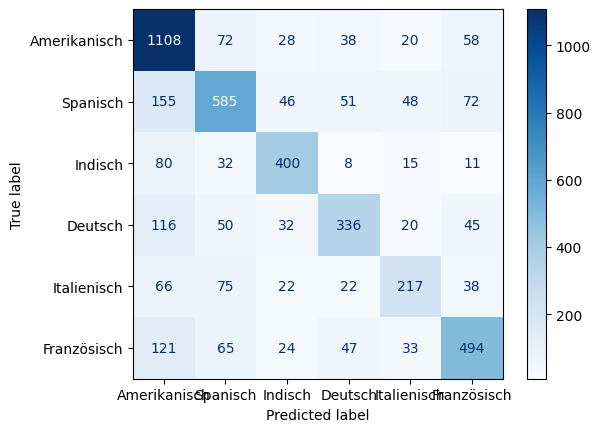

In [18]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(actual_labels, pred_labels)

# Remove '<unk>' if it's not present in the predictions
display_labels = list(language_mapping.keys())
if '<unk>' not in pred_labels:
    display_labels.remove('<unk>')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)
disp.plot(cmap='Blues')
plt.show()